In [ ]:
!nvidia-smi

Tue Jan  9 03:10:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              50W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install transformers

In [ ]:
#Importing required libraries
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import shutil
import sys

In [ ]:
train_path = "/content/IMDB Dataset-1.csv"

In [ ]:
# Trying to read the CSV file with different encodings
try:
    train_dff = pd.read_csv(train_path, encoding='utf-8')
except UnicodeDecodeError:
    try:
        train_dff = pd.read_csv(train_path, encoding='ISO-8859-1')
    except UnicodeDecodeError:
        train_dff = pd.read_csv(train_path, encoding='cp1252')

In [ ]:
# We can also print the first few rows to verify if the data is loaded correctly
train_dff.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df = pd.get_dummies(train_dff, columns=['sentiment'], prefix='sentiment')

In [ ]:
target_list = ['sentiment']

In [ ]:
#Defining Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 1e-05

In [ ]:
#Checking a random review
print(df['review'][0])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Function to clean a single review
def clean_review(review):
    # Removing HTML tags and line breaks
    cleaned_text = re.sub(r'<br\s*/*>', ' ', review)
    cleaned_text = re.sub(r'<[^>]*>', '', cleaned_text)

    # Tokenizing and removing stopwords
    stop_words = set(stopwords.words('english'))
    words = re.findall(r'\b\w+\b', cleaned_text.lower())
    filtered_words = [word for word in words if word not in stop_words]

    # Applying Porter stemming
    porter = PorterStemmer()
    stemmed_words = [porter.stem(word) for word in filtered_words]

    # Joining the stemmed words back into a cleaned text
    cleaned_text = ' '.join(stemmed_words)
    return cleaned_text

# Applying the cleaning function to the 'review' column
df['cleaned_review'] = df['review'].apply(clean_review)

# Printing the cleaned dataset
print(df[['review', 'cleaned_review']])

                                                  review  \
0      One of the other reviewers has mentioned that ...   
1      A wonderful little production. <br /><br />The...   
2      I thought this was a wonderful way to spend ti...   
3      Basically there's a family where a little boy ...   
4      Petter Mattei's "Love in the Time of Money" is...   
...                                                  ...   
49995  I thought this movie did a down right good job...   
49996  Bad plot, bad dialogue, bad acting, idiotic di...   
49997  I am a Catholic taught in parochial elementary...   
49998  I'm going to have to disagree with the previou...   
49999  No one expects the Star Trek movies to be high...   

                                          cleaned_review  
0      one review mention watch 1 oz episod hook righ...  
1      wonder littl product film techniqu unassum old...  
2      thought wonder way spend time hot summer weeke...  
3      basic famili littl boy jake think zo

In [ ]:
df.head()

,review,sentiment_negative,sentiment_positive,cleaned_review
0,One of the other reviewers has mentioned that ...,0,1,one review mention watch 1 oz episod hook righ...
1,A wonderful little production. <br /><br />The...,0,1,wonder littl product film techniqu unassum old...
2,I thought this was a wonderful way to spend ti...,0,1,thought wonder way spend time hot summer weeke...
3,Basically there's a family where a little boy ...,1,0,basic famili littl boy jake think zombi closet...
4,"Petter Mattei's ""Love in the Time of Money"" is...",0,1,petter mattei love time money visual stun film...


In [ ]:
target_list = ['sentiment_positive','sentiment_negative']

In [ ]:
df.drop(labels=['review'], axis=1, inplace=True)
df = df[['cleaned_review','sentiment_positive','sentiment_negative']]

In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['cleaned_review']
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }

In [ ]:
train_size = 0.8
train_df = df.sample(frac=train_size, random_state=200).reset_index(drop=True)
val_df = df.drop(train_df.index).reset_index(drop=True)

In [ ]:
# Training and validation split
train_size = 0.8
train_df = df.sample(frac=train_size, random_state=200)
val_df = df.drop(train_df.index)

# Remaining data is now in val_df, splitting this into validation and test
val_size = 0.5  # 50% of the remaining data for validation
val_df = val_df.sample(frac=val_size, random_state=200)
test_df = val_df.drop(val_df.index)

# Resetting index for all dataframes
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
train_df.head()

,cleaned_review,sentiment_positive,sentiment_negative
0,shame repres high point career master ingmar b...,1,0
1,rosalind russel execut power hous perform rosi...,1,0
2,give movi 2 star pure slightli liber plot line...,0,1
3,show last 1980 moment plot usual dishwat thin ...,0,1
4,jessica ghost stori name impli ghost stori the...,0,1


In [ ]:
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)

In [ ]:
train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into
    optimizer: optimizer we defined in previous training
    """
    # loading check point
    checkpoint = torch.load(checkpoint_fpath)
    # initializing state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initializing optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initializing valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # returning model, optimizer, epoch value, min validation loss
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # saving checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copying that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
val_targets=[]
val_outputs=[]

In [ ]:
def train_model(n_epochs, training_loader, validation_loader, model,
                optimizer, checkpoint_path, best_model_path):

  # initializing tracker for minimum validation loss
  valid_loss_min = np.Inf


  for epoch in range(1, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        #if batch_idx%5000==0:
         #   print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('before loss data in training', loss.item(), train_loss)
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        #print('after loss data in training', loss.item(), train_loss)

    print('############# Epoch {}: Training End     #############'.format(epoch))

    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    ######################
    # validate the model #
    ######################

    model.eval()

    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculating average losses
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # printing training/validation statistics
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
            ))

      # creating checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }

        # save checkpoint
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)

      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))

  return model

In [ ]:
ckpt_path = "/content/curr_ckpt"
best_model_path = "/content/best_model.pt"

In [ ]:
trained_model = train_model(EPOCHS, train_data_loader, val_data_loader, model, optimizer, ckpt_path, best_model_path)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.000292 	Average Validation Loss: 0.001869
Validation loss decreased (inf --> 0.001869).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.000191 	Average Validation Loss: 0.001631
Validation loss decreased (0.001869 --> 0.001631).  Saving model ...
############# Epoch 2  Done   #############



In [ ]:
example = val_df['cleaned_review'][2]
encodings = tokenizer.encode_plus(
    example,
    None,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    return_token_type_ids=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)
model.eval()
with torch.no_grad():
    input_ids = encodings['input_ids'].to(device, dtype=torch.long)
    attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
    token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
    output = model(input_ids, attention_mask, token_type_ids)
    final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
    print(train_df.columns[1:].to_list()[int(np.argmax(final_output, axis=1))])

sentiment_negative


In [ ]:
df[df['sentiment_negative']==1]

,cleaned_review,sentiment_positive,sentiment_negative
3,basic famili littl boy jake think zombi closet...,0,1
7,show amaz fresh innov idea 70 first air first ...,0,1
8,encourag posit comment film look forward watch...,0,1
10,phil alien one quirki film humour base around ...,0,1
11,saw movi 12 came recal scariest scene big bird...,0,1
...,...,...,...
49994,typic junk comedi almost laugh genuin moment m...,0,1
49996,bad plot bad dialogu bad act idiot direct anno...,0,1
49997,cathol taught parochi elementari school nun ta...,0,1
49998,go disagre previou comment side maltin one sec...,0,1


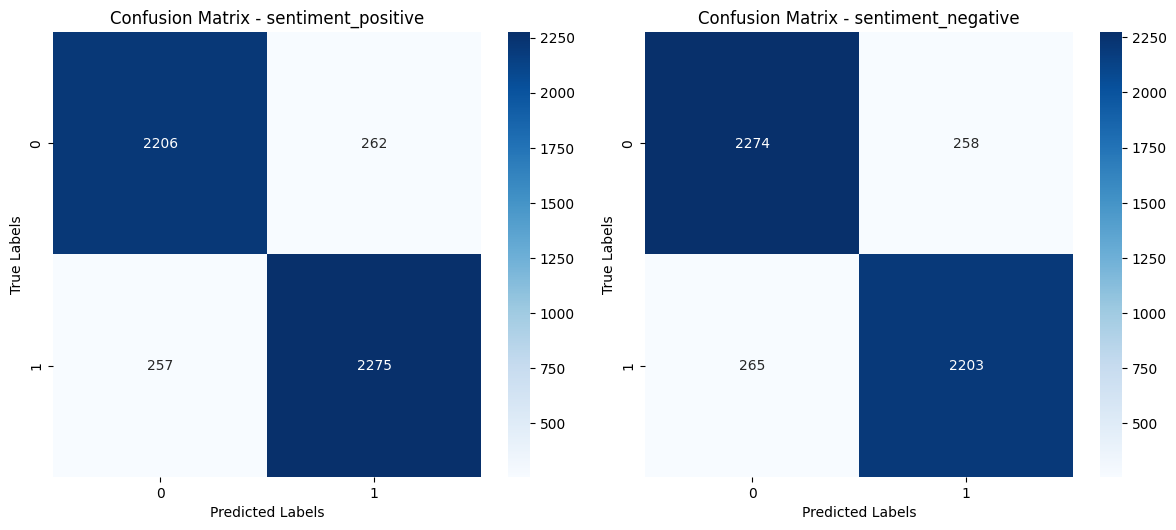

                    precision    recall  f1-score   support

sentiment_positive       0.90      0.90      0.90      2532
sentiment_negative       0.90      0.89      0.89      2468

         micro avg       0.90      0.90      0.90      5000
         macro avg       0.90      0.90      0.90      5000
      weighted avg       0.90      0.90      0.90      5000
       samples avg       0.89      0.90      0.90      5000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming we have a true labels column in your test_df, replace 'true_labels_column' with the actual column name
true_labels = val_df[['sentiment_positive', 'sentiment_negative']]  # Replace with actual column names

# Initializing lists to store predicted labels and probabilities
predicted_probabilities = []

# Iterating over the test dataset
for example in val_df['cleaned_review']:
    # Tokenizing the example using the provided tokenizer
    encodings = tokenizer.encode_plus(
        example,
        None,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_token_type_ids=True,
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Moving inputs to the appropriate device (e.g., GPU)
    with torch.no_grad():
        input_ids = encodings['input_ids'].to(device, dtype=torch.long)
        attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)

        # Forwarding pass
        output = model(input_ids, attention_mask, token_type_ids)

        # Applying sigmoid activation and convert to numpy array
        final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()

        # Appending predicted probability to the list
        predicted_probabilities.append(final_output)

# Flattening the predicted probabilities to get probabilities for each class
predicted_probabilities = [item for sublist in predicted_probabilities for item in sublist]

# Converting predicted probabilities to binary predictions (assuming a threshold of 0.5)
predicted_labels = [[1 if prob >= 0.5 else 0 for prob in example] for example in predicted_probabilities]

# Creating a multi-label confusion matrix
conf_matrix = multilabel_confusion_matrix(true_labels, predicted_labels)

# Displaying the confusion matrix
plt.figure(figsize=(12, 10))
for i, label in enumerate(train_df.columns[1:]):
    plt.subplot(2, 2, i + 1)
    sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {label}')

plt.tight_layout()
plt.show()

# Displaying classification report
print(classification_report(true_labels, predicted_labels, target_names=train_df.columns[1:]))


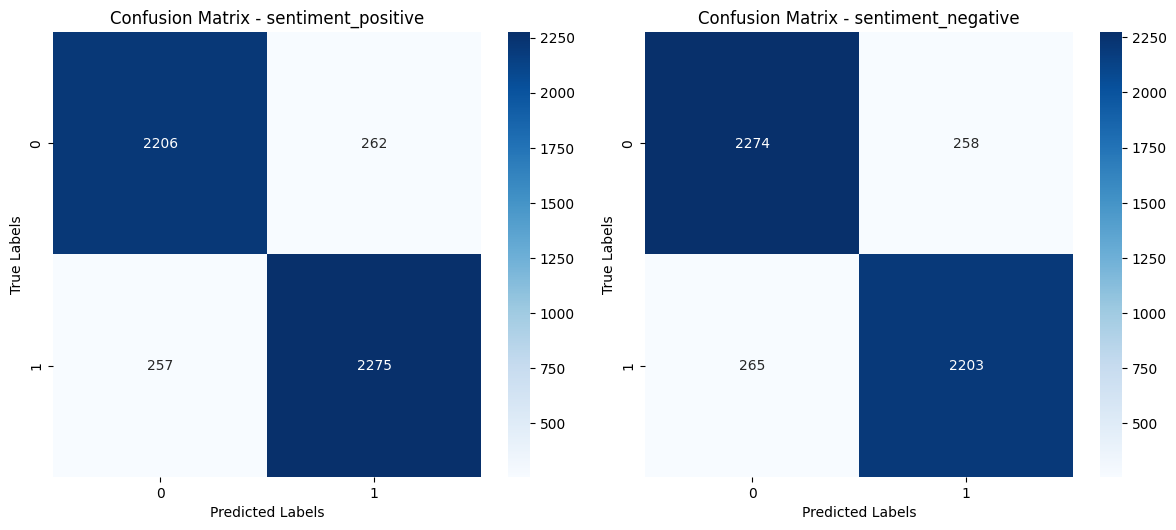

                    precision    recall  f1-score   support

sentiment_positive       0.90      0.90      0.90      2532
sentiment_negative       0.90      0.89      0.89      2468

         micro avg       0.90      0.90      0.90      5000
         macro avg       0.90      0.90      0.90      5000
      weighted avg       0.90      0.90      0.90      5000
       samples avg       0.89      0.90      0.90      5000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import torch

# Assuming we have a true labels column in your test_df, replace 'true_labels_column' with the actual column name
true_labels = val_df[['sentiment_positive', 'sentiment_negative']]  # Replace with actual column names

# Initializing lists to store predicted labels and probabilities
predicted_probabilities = []

# Iterating over the test dataset
for example in val_df['cleaned_review']:
    # Tokenizing the example using the provided tokenizer
    encodings = tokenizer.encode_plus(
        example,
        None,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_token_type_ids=True,
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Moving inputs to the appropriate device (e.g., GPU)
    with torch.no_grad():
        input_ids = encodings['input_ids'].to(device, dtype=torch.long)
        attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)

        # Forwarding pass
        output = model(input_ids, attention_mask, token_type_ids)

        # Applying sigmoid activation and convert to numpy array
        final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()

        # Appending predicted probability to the list
        predicted_probabilities.append(final_output)

# Flattening the predicted probabilities to get probabilities for each class
predicted_probabilities = [item for sublist in predicted_probabilities for item in sublist]

# Converting predicted probabilities to binary predictions (assuming a threshold of 0.5)
predicted_labels = [[1 if prob >= 0.5 else 0 for prob in example] for example in predicted_probabilities]

# Creating a multi-label confusion matrix
conf_matrix = multilabel_confusion_matrix(true_labels, predicted_labels)

# Displaying the confusion matrix
plt.figure(figsize=(12, 10))
for i, label in enumerate(train_df.columns[1:]):
    plt.subplot(2, 2, i + 1)
    sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {label}')

plt.tight_layout()
plt.show()

# Displaying classification report
print(classification_report(true_labels, predicted_labels, target_names=train_df.columns[1:]))

# Identifying examples where the model predicted the wrong labels
wrong_predictions = []

for i, (true_label, predicted_label, example) in enumerate(zip(true_labels.values, predicted_labels, test_df['cleaned_review'])):
    if any(true_label != predicted_label):
        wrong_predictions.append((i, true_label, predicted_label, example))

# Displaying the first few examples of wrong predictions
num_wrong_predictions_to_display = min(5, len(wrong_predictions))
for i in range(num_wrong_predictions_to_display):
    index, true_label, predicted_label, example = wrong_predictions[i]

    print(f"\nExample {index + 1} - True Labels: {true_label}, Predicted Labels: {predicted_label}")
    print(f"Review Text: {example}\n")

In [ ]:
len(predicted_labels)

5000